<a href="https://colab.research.google.com/github/AliTavakoli2001/Deep-Learning-Project/blob/main/Variational%20Autoencoder%20(VAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the MNIST Dataset

This code loads the MNIST dataset, normalizes pixel values to the range [0,1], and reshapes the images to (28, 28, 1) for use in a convolutional neural network.

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np

# Load the dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add a channel dimension
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Define the Encoder Model
This code defines the encoder for the VAE model. Instead of mapping inputs directly to a compressed space, it learns a distribution (mean & variance) and samples from it using the reparameterization trick.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

latent_dim = 2  # Dimension of the latent space

# Define the input layer
inputs = Input(shape=(28, 28, 1))

# Convolutional layers for feature extraction
x = Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(inputs)
x = Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(16, activation="relu")(x)

# Define mean and log variance for the latent space
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function using the reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Define the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 32)     │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 2)              │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

# Define the Decoder Model
The decoder reconstructs images from the latent space by upsampling the feature maps using Conv2DTranspose layers

In [ ]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose

# Define the decoder input
latent_inputs = Input(shape=(latent_dim,))

# Reconstruct the image from the latent space
x = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x)
outputs = Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same")(x)

# Define the decoder model
decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

# Define the VAE Model and Loss Function
This code defines the VAE model and its loss function, which includes:

1️⃣ Reconstruction Loss: Measures how well the model reconstructs the input.

2️⃣ KL Divergence: Regularizes the latent space to follow a normal distribution.

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer  # Import Layer class

# Define the VAE model
outputs = decoder(encoder(inputs)[2])  # Use the sampled latent variable z
vae = Model(inputs, outputs, name="vae")

# Custom layer to compute reconstruction loss
class ReconstructionLossLayer(Layer):
    def __init__(self, **kwargs):
        super(ReconstructionLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        original_inputs, reconstructed_outputs = inputs  # Unpack inputs
        # Compute Reconstruction Loss
        reconstruction_loss = binary_crossentropy(K.flatten(original_inputs), K.flatten(reconstructed_outputs))
        reconstruction_loss *= 28 * 28  # Scale the loss
        # Add loss to the model
        self.add_loss(K.mean(reconstruction_loss))  # Add loss directly in the layer
        return reconstructed_outputs  # Pass through the reconstructed output

# Apply

# Adding KL Divergence Loss as a Custom Layer
we define another custom layer to compute the KL Divergence Loss. This loss ensures that the latent space follows a normal distribution.
his layer takes the z_mean and z_log_var (from the encoder) as inputs.

In [ ]:
# Custom layer to compute the KL Divergence loss
class KLDivergenceLossLayer(Layer):
    def __init__(self, **kwargs):
        super(KLDivergenceLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs  # Unpack inputs
        # Compute KL Divergence Loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_loss))  # Add loss directly in the layer
        return inputs  # Pass through the inputs


# Connecting Loss Layers to the Model
We pass the encoded representation (latent variable z) through the decoder to reconstruct the input.

The ReconstructionLossLayer is applied to compute the reconstruction loss.

The output of this layer is used as the final output of the model.

In [ ]:
# Connect the loss layers to the model
outputs = decoder(encoder(inputs)[2])  # Use the sampled latent variable z
vae = Model(inputs, ReconstructionLossLayer()([inputs, outputs]), name="vae")


# Compile the VAE Model

In [ ]:
# Compile the model before training
vae.compile(optimizer="adam")


# Train the VAE Model
The model is trained using 50 epochs and a batch size of 128. The validation dataset (x_test) is used to monitor performance.

In [ ]:
# Train the VAE model
vae.fit(x_train, x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, x_test))


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 269.9289 - val_loss: 189.3404
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 187.9587 - val_loss: 184.2770
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 184.2341 - val_loss: 180.6204
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 181.0976 - val_loss: 178.3337
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 178.5123 - val_loss: 176.0392
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 176.8216 - val_loss: 175.0184
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 175.8469 - val_loss: 173.4400
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 174.2646 - val_loss: 172.2797
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 173.0152 - val_loss: 171.7553
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 172.2525 - val_loss: 171.5362
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 172.2822 - val_loss: 170.3234
Epoch 

# Generating New Images from the Latent Space
We sample random latent vectors from a standard normal distribution.

The decoder converts these latent vectors into generated images.

This allows us to create entirely new handwritten digits that resemble MNIST.

In [ ]:
# Generate new images by sampling from the latent space
def generate_images(decoder, n=10):
    random_latent_vectors = np.random.normal(size=(n, latent_dim))  # Sample random points from a normal distribution
    generated_images = decoder.predict(random_latent_vectors)  # Decode the latent vectors into images
    return generated_images


# Visualizing Generated Images
We use Matplotlib to visualize the generated images.

The function iterates over n generated images, reshapes them to 28×28 pixels, and displays them in grayscale.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


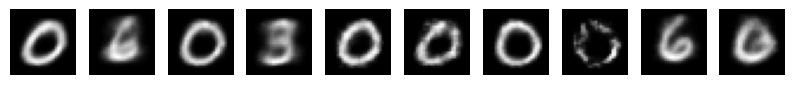

In [ ]:
import matplotlib.pyplot as plt

# Function to display generated images
def plot_generated_images(images, n=10):
    plt.figure(figsize=(10, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

# Generate and display images
generated_images = generate_images(decoder, n=10)
plot_generated_images(generated_images)
